In [53]:
import sys
sys.path.append('../../30_data_tools/')

from helper import load_dotenv
from get_labelstudio_data import get_results_of_project
from file_interaction import open_img, get_related_filepath, get_generic_image_filepath

In [132]:
from PIL import Image
import numpy as np
from skimage.filters import difference_of_gaussians
from scipy import ndimage
import sqlite3
import pandas as pd
import plotly.express as px
import math
from tqdm.auto import tqdm

In [138]:
Image.MAX_IMAGE_PIXELS = None

In [74]:
def get_fft( input_img ):
    ft = np.fft.ifftshift( input_img )
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    
    return ft

def invert_fft (input_real, input_imaginary):
    input = (input_real + 1j * input_imaginary)
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

In [3]:
def limit_frequencies( fft, inner_limit=None, outer_limit=None ):
    center = (fft.shape[1] / 2, fft.shape[0] / 2)
    for y in range(fft.shape[0]):
        for x in range(fft.shape[1]):
            r = math.sqrt( abs(center[0] - x) ** 2 + abs(center[1] - y) ** 2 )
            
            if outer_limit is not None and r > outer_limit:
                fft[y,x] = 0
    
            if inner_limit is not None and r < inner_limit:
                fft[y,x] = 0

    return fft

In [91]:
def get_spherical_coordinate( x, y ):
    r = math.sqrt( x ** 2 + y ** 2 )
    angle = math.degrees(math.atan2(y,x))

    return r, angle

In [92]:
def get_main_impulses( input, relevant_level=0.66 ):
    y_positions, x_positions = np.where(input >= input.max() * relevant_level)
    main_impulses = []

    for i in range(y_positions.shape[0]):
            x = x_positions[i] - input.shape[1] / 2
            y = y_positions[i] - input.shape[0] / 2
            
            r, angle = get_spherical_coordinate(x,y)
            #angle += 90 # Anpassung um 0° in der vertikalen, nicht der horizontalen zu haben
            intensity = input[y_positions[i],x_positions[i]]
        
            main_impulses.append((r, angle, intensity))

    return main_impulses

In [94]:
def normalize_impulses( impulses ):
    normalized_impulses = {}
    
    for r, angle, intensity in impulses:
        r = round(r)
        angle = round(angle)
    
        if angle >= 0 and angle < 180:
            key = (r,angle)
    
            if key not in normalized_impulses:
                normalized_impulses[key] = []
    
            normalized_impulses[key].append(intensity)
    
    return [
        (key[0], key[1], sum(normalized_impulses[key]) / len(normalized_impulses[key]))
        for key in normalized_impulses
    ]

In [95]:
# anzahl der Hauptimpulse
# Clusteranalyse
def get_clusters_of_impulses( impulses, max_distance=5 ):
    clusters = []
    sorted_impulses = [False for imp in impulses]
    
    def sort_impulse( imp_index ):
        imp = impulses[imp_index]
        connected_impulses = [imp]
        sorted_impulses[imp_index] = True
    
        for i in range(len(impulses)):
            if sorted_impulses[i] == False:
                imp2 = impulses[i]
                distance = math.sqrt(
                    abs(imp[0] - imp2[0]) ** 2 +
                    abs(imp[1] - imp2[1]) ** 2
                )
    
                if distance <= max_distance:
                    connected_impulses += sort_impulse( i )
    
        return connected_impulses
    
    
    while False in sorted_impulses:
        clusters.append( sort_impulse(sorted_impulses.index(False)) )

    return clusters

In [17]:
dotenv = load_dotenv()
con = sqlite3.connect( dotenv['DB_PATH'] )

In [30]:
masks = pd.read_sql(
    f'''
        SELECT * FROM mask
        WHERE job='24-03-05-01_randomTrainPages'
    ''',
    con
)
masks.loc[
    :,
    'bbox'
] = masks.bbox.apply( lambda entry: [int(val) for val in entry.split(';')])

masks = pd.merge(
    masks,
    pd.DataFrame(
        [(r['id'],r['labels'][0]) for r in get_results_of_project(2) if 'id' in r],
        columns=['mask_id','label']
    ),
    how="left",
    on="mask_id"
)

In [179]:
sample = masks.sample(n=1)

In [167]:
for idx in tqdm(sample.index):
    row = masks.loc[idx]
    
    original_filepath = get_related_filepath( row.job, row.variant_name, f'{row.pdf_filename}.4c.jpg' )
    generic_filepath = get_generic_image_filepath( row.pdf_filename, row.job, row.method, row.idx, variant='4c' )
    
    original_img = open_img( original_filepath ).crop((
        row.bbox[0],row.bbox[1],
        row.bbox[0]+row.bbox[2],row.bbox[1]+row.bbox[3]
    ))
    
    generic_img = open_img( generic_filepath ).crop((
        row.bbox[0],row.bbox[1],
        row.bbox[0]+row.bbox[2],row.bbox[1]+row.bbox[3]
    ))
    
    diff_img = np.array( original_img )[:,:,3] - np.array( generic_img )[:,:,3]
    fft = get_fft(np.array( original_img )[:,:,3])
    fft = limit_frequencies( fft, inner_limit=max(fft.shape) * 0.1 )
    filtered = ndimage.uniform_filter( np.abs(fft) , size=10)
    dog_fft = difference_of_gaussians( filtered, 1.5 )
    
    masks.loc[
        idx,
        'threshold_sum'
    ] = dog_fft[dog_fft > dog_fft.max() * 0.66].sum()

  0%|          | 0/1 [00:00<?, ?it/s]

TypeError: cannot unpack non-iterable NoneType object

In [183]:
row = sample.iloc[0]
row

pdf_filename                     122079.046-049_disney_feiern.p4
job                                 24-03-05-01_randomTrainPages
type                                                          4c
variant_name                                      halftone600dpi
method                                                soft_light
idx                                                            1
bbox                                      [1328, 620, 1272, 808]
ssim                                                    0.999308
mask_id                temp_f23e8264-9737-45a9-a1a7-c07b767a44a2
overlay_intensity_C                                          0.0
overlay_intensity_M                                          0.0
overlay_intensity_Y                                          0.0
overlay_intensity_K                                          1.0
pattern                                         pattern_line_040
pattern_position                                      -497;-2399
label                    

In [184]:
f'{row.pdf_filename}.4c_600.jpg'

'122079.046-049_disney_feiern.p4.4c_600.jpg'

In [190]:
get_related_filepath( row.job, 'ps2400dpi150lpi', f'{row.pdf_filename}.4c_600.jpg' )

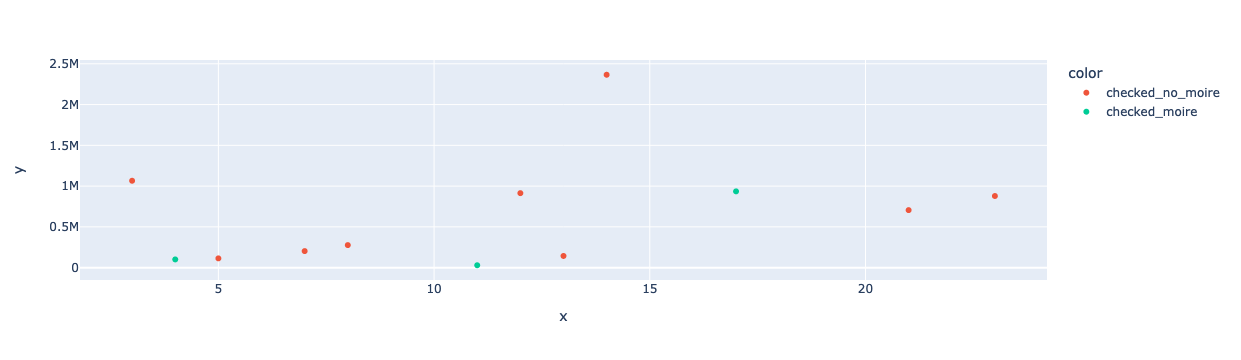

In [160]:
px.scatter(
    x=[i for i in range(masks.loc[pd.isna(masks.threshold_sum) == False].shape[0])],
    y=masks.loc[pd.isna(masks.threshold_sum) == False].threshold_sum,
    color=masks.loc[pd.isna(masks.threshold_sum) == False].label
)

In [143]:
all_impulses = get_main_impulses( dog_fft )
normalized_impulses = normalize_impulses( all_impulses )
clusters = get_clusters_of_impulses( normalized_impulses )

In [150]:
masks.loc[pd.isna(masks.mse) == False].mse

176     0.004311
180     0.002312
220     0.000030
283     0.000018
419     0.000304
481     2.213537
499     0.013955
539     0.007429
619     0.008447
644     0.002629
655     0.028872
710     0.000057
858     1.363584
1052    0.000014
1097    0.080180
1124    0.000071
1169    0.041972
1286    0.104984
1344    0.000641
1589    0.004390
1669    0.066855
1847    0.005955
1888    0.096524
2029    0.000014
2186    0.046356
2189    0.000101
2339    0.005474
2637    0.149863
2970    0.001870
3228    0.018925
Name: mse, dtype: float64

In [149]:
masks.loc[idx].mse

2.2135367495132354

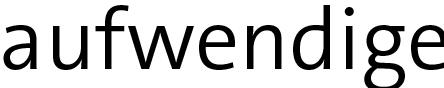

In [144]:
original_img

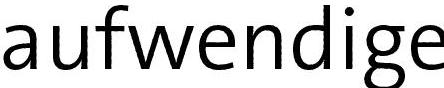

In [145]:
generic_img